In [1]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import cv2

In [2]:
def show_two_imgs(image1, image2, figsize=(16, 6), filename = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.imshow(image1)
    ax2.imshow(image2)

    ax1.axis('off')
    ax2.axis('off')

    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()


def plot_vertical_projection(vertical_projection, peaks, filename = None):
    plt.plot(vertical_projection, color='blue', label='Vertical Projection')
    plt.scatter(peaks, vertical_projection[peaks], color='red', marker='o', label='Peaks')

    plt.title('Vertical Projection and Peaks')
    plt.xlabel('Column')
    plt.ylabel('Sum of Pixel Values')
    plt.grid(True)
    plt.legend()

    if filename is not None:
        plt.savefig(filename)
    plt.show()
    plt.close()


def plot_fitting_lines(mask, lines, filename = None):
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    plt.figure(figsize=(3, 5))

    for line in lines:
        y = np.linspace(0, mask.shape[0]-1, mask.shape[0])
        x = np.polyval(line, y)
        plt.plot(x, y, linewidth=2)

    plt.axis('off')
    plt.imshow(color_warp)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True, dpi=130)
    plt.show()
    plt.close()


def plot_filter_lines(mask, lines, filename = None):
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    plt.figure(figsize=(3, 5))

    for (x, y) in lines:
        plt.plot(x, y, linewidth=2)

    plt.axis('off')
    plt.imshow(color_warp)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True, dpi=130)
    plt.show()
    plt.close()

## 将前视图转为鸟瞰图

将前视图转为鸟瞰图的方法有两种：

- 有标定的情况下，可以直接使用标定参数进行转换。
- 没有标定的情况下，可以选择四个点计算透视变换矩阵来进行转换。

在没有标定的情况下，透视变换需要使用一个3x3的变换矩阵，确保直线在变换后仍然保持直线的性质。为了得到这个变换矩阵，需要在输入图像上选择4个点，并提供它们在输出图像上的对应点。这4个点中，至少有3个点不能共线。通过使用`cv2.getPerspectiveTransform`函数，可以计算出这个变换矩阵，随后可以通过`cv2.warpPerspective`将其应用于图像。

简而言之，透视变换需要选取4个非共线的点，并通过这些点之间的映射关系来计算变换矩阵，最终应用于图像。

<div style="text-align: center;">
    <img src="doc/example_00.png" alt="Your Image">
</div>

以上图为例，选择1，2，3，4四个点，用以进行透视变换。经查阅，高速公路上的白色虚线标准长度为长度6米，间隔9米。高速公路单条车道宽度是3.75米。这里假定，直线14，直线23长4米，直线12，直线34长30米。则输入图像与输出图像点的坐标如上图所示。

In [3]:
# GET MATRIX
src = np.float32([
    (243.3086, 2006.09253), (987.90594, 1271.23894),
    (1410.03022, 1272.49526), (2073.4596, 2003.7979)
])
dst = np.float32([
    (90, 500), (90, 200), (130, 200), (130, 500)
])
Matrix = cv2.getPerspectiveTransform(src, dst)
print(f"==>> Matrix: {Matrix}")

==>> Matrix: [[-1.94539874e-02 -1.06050631e-01  1.35107934e+02]
 [ 1.91974907e-03 -5.63565578e-01  6.72471141e+02]
 [ 4.05508358e-06 -9.55209973e-04  1.00000000e+00]]


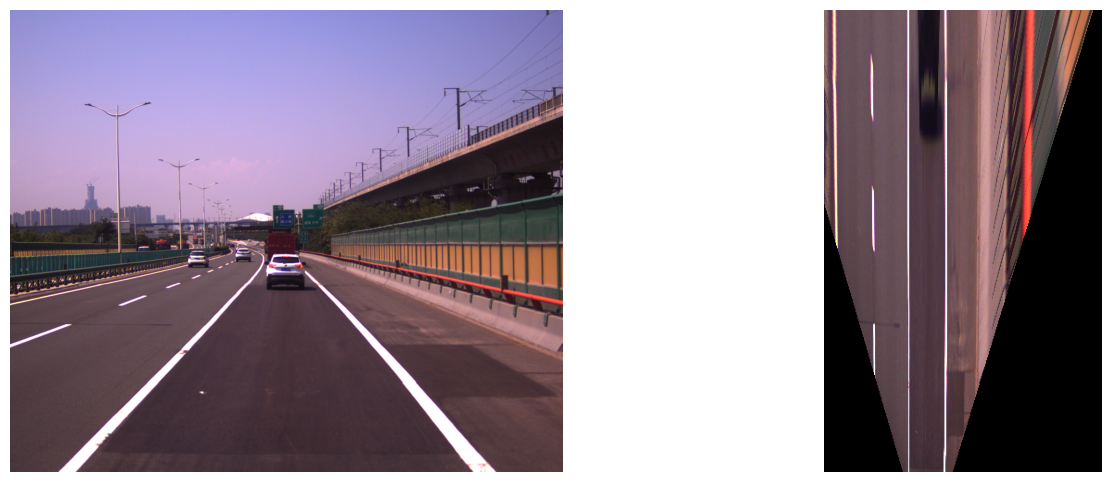

In [4]:
image = cv2.imread('./data/input/0000000100.bmp')
warped_image = cv2.warpPerspective(image, Matrix, (300, 500))

show_two_imgs(image[:,:,::-1], warped_image[:,:,::-1])

## 车道线定位

假设已经获得了车道线的分割图像，并将其转换为鸟瞰图。

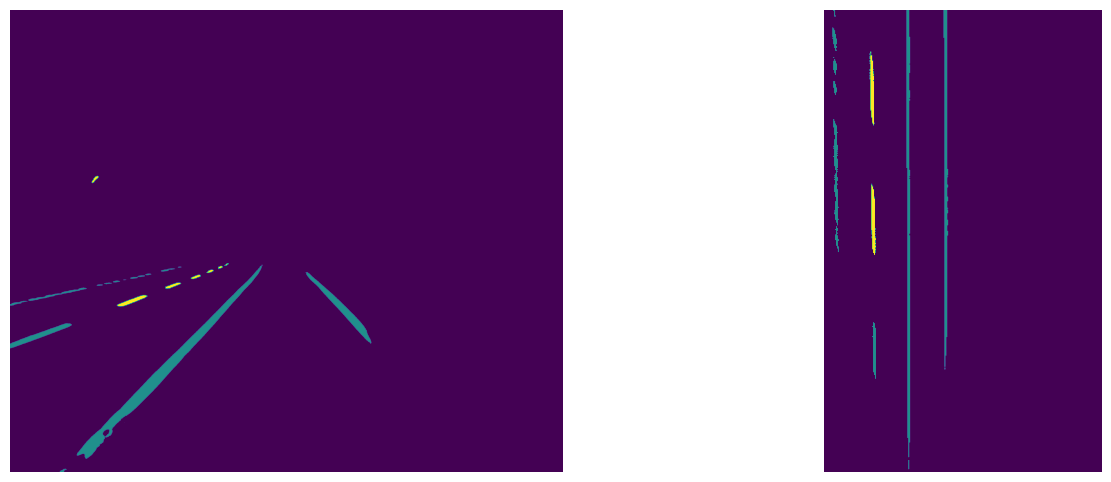

In [5]:
mask = np.load('./data/input/0000000100.npy')
warped_mask = cv2.warpPerspective(mask, Matrix, (300, 500))

show_two_imgs(mask, warped_mask)

现在有了车道线分割图的鸟瞰图，那么如何确定当前有几条车道线以及车道线所处的位置呢？

可以对鸟瞰图进行垂直方向的累加投影。理论上，有几个峰值就有几条车道线，而峰值点的位置即为车道线的位置坐标。

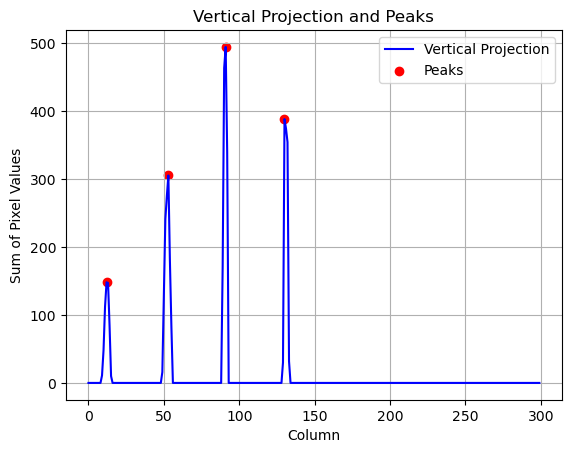

In [6]:
# 计算垂直方向的像素值累加投影
vertical_projection = np.sum(warped_mask, axis=0)
# 使用find_peaks函数查找峰值点
peaks, _ = find_peaks(vertical_projection, height=0)

plot_vertical_projection(vertical_projection, peaks)

从上图可以看出，一共有四条车道线，且车道线的大致位置也是已知的。之后可以通过滑动窗口法，以峰值点为起点对车道线的点进行搜索。

滑动窗口法的工作原理如下：

1. 设置窗口大小
    - 确定窗口的宽度和高度，通常是矩形区域。
    - 窗口的高度可以根据图像的大小和问题的特定要求进行调整。
2. 滑动窗口
    - 从图像底部开始，以固定步长（通常是一个窗口的高度）向上滑动窗口。
    - 对于每个窗口，统计窗口内的非零像素的个数
3. 更新窗口
    - 若窗口内的非零像素数量超过阈值，更新窗口中心位置为当前窗口内非零像素的平均横坐标。
4. 拟合曲线
    - 针对每个滑动窗口内的非零像素，使用 `np.polyfit` 对这些点进行二阶多项式拟合，得到曲线的系数。

In [7]:
def finding_line(warped_mask, x_points, sliding_window_num=9, margin=15, min_pixels_threshold=50):
    # 获取图像的高度和宽度
    height, width = warped_mask.shape

    # 获取图像中所有非零像素的坐标
    nonzero_y, nonzero_x = np.nonzero(warped_mask)

    # 计算滑动窗口的高度
    sliding_window_height = height // sliding_window_num

    # 用于存储每个滑动窗口内的像素索引
    line_pixel_indexes = [[] for _ in range(len(x_points))]

    # 遍历滑动窗口
    for i in range(sliding_window_num):
        for idx, x_point in enumerate(x_points):
            # 确定窗口在y轴上的边界
            top, bottom = height - (i + 1) * sliding_window_height, height - i * sliding_window_height

            # 确定窗口在x轴上的边界
            left, right = x_point - margin, x_point + margin

            # 获取窗口内的非零像素索引
            window_pixel_indexes = ((nonzero_y >= top) & (nonzero_y < bottom) &
                                    (nonzero_x >= left) & (nonzero_x < right)).nonzero()[0]

            # 存储当前窗口内的像素索引
            line_pixel_indexes[idx].append(window_pixel_indexes)

            # 如果像素数量足够，更新窗口中心位置
            if len(window_pixel_indexes) > min_pixels_threshold:
                x_point = int(np.mean(nonzero_x[window_pixel_indexes]))

    # 用于存储拟合的曲线系数
    lines = []

    # 处理每个滑动窗口的像素索引
    for line_pixel_index in line_pixel_indexes:
        # 合并像素索引
        line_pixel_index = np.concatenate(line_pixel_index)

        # 提取坐标
        line_x, line_y = nonzero_x[line_pixel_index], nonzero_y[line_pixel_index]

        # 使用多项式拟合曲线，并将结果添加到lines中
        lines.append(np.polyfit(line_y, line_x, 2))

    return lines

[array([1.65758116e-05, 7.24890062e-03, 1.07169591e+01]),
 array([-7.40176124e-06,  1.29702042e-02,  5.02335962e+01]),
 array([-4.84955527e-06,  4.68389784e-03,  8.99516626e+01]),
 array([-1.80479860e-05,  6.97896625e-03,  1.30515299e+02])]


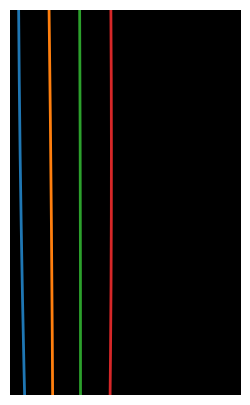

In [8]:
lines = finding_line(warped_mask, peaks)
pprint(lines)
plot_fitting_lines(warped_mask, lines)

上述为拟合后的车道线在鸟瞰图上的效果。

## 复杂情况

然而，上述结果是在理想条件下（车道线分割结果准确无误、车道线曲率不大）得到的结果。当情况复杂时，直接以峰值点作为车道线的个数以及大致位置的方式可能行不通。

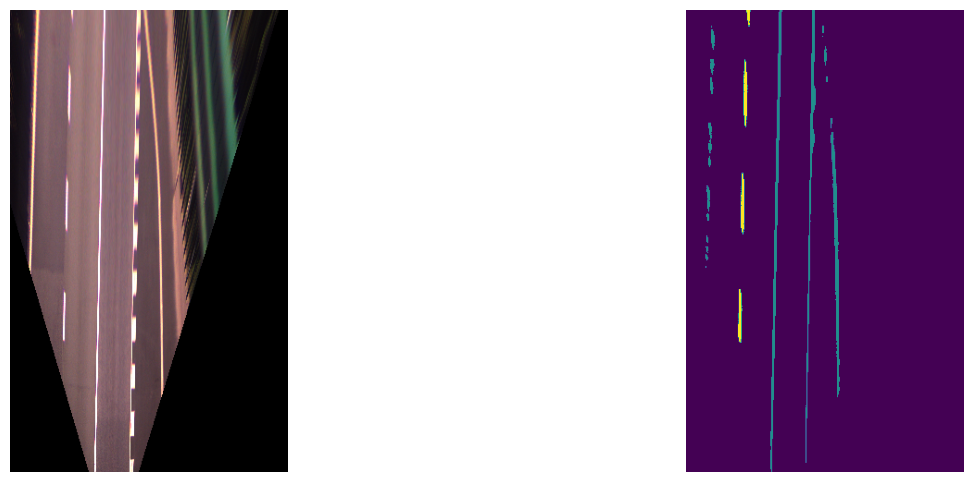

In [9]:
image = cv2.imread('./data/input/0000000000.bmp')
warped_image = cv2.warpPerspective(image, Matrix, (300, 500))

mask = np.load('./data/input/0000000000.npy')
warped_mask = cv2.warpPerspective(mask, Matrix, (300, 500))

show_two_imgs(warped_image[:,:,::-1], warped_mask)

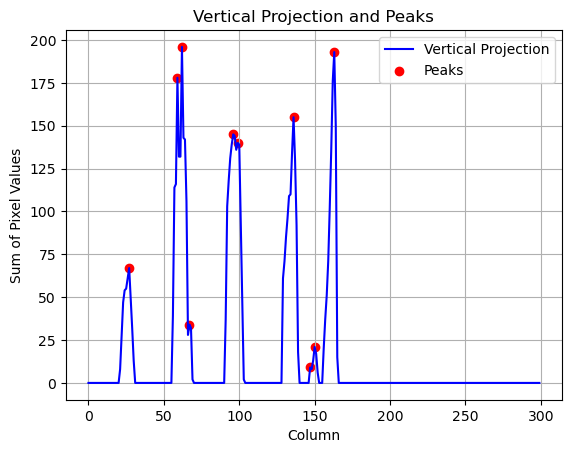

In [10]:
# 计算垂直方向的像素值累加投影
vertical_projection = np.sum(warped_mask, axis=0)
# 使用find_peaks函数查找峰值点
peaks, _ = find_peaks(vertical_projection, height=0)

plot_vertical_projection(vertical_projection, peaks)

[array([-1.30352505e-05, -2.30486201e-02,  2.90220098e+01]),
 array([ 2.12480717e-05, -3.31642565e-02,  6.65330824e+01]),
 array([ 2.12480717e-05, -3.31642565e-02,  6.65330824e+01]),
 array([ 2.12480717e-05, -3.31642565e-02,  6.65330824e+01]),
 array([ 2.43088698e-06, -2.16520833e-02,  1.01486570e+02]),
 array([ 2.43088698e-06, -2.16520833e-02,  1.01486570e+02]),
 array([ 3.01406741e-05, -3.71399438e-02,  1.40104435e+02]),
 array([-3.82394468e-04,  1.47921803e-01,  1.32594874e+02]),
 array([-1.86209555e-04,  1.61076093e-01,  1.30772753e+02]),
 array([-1.39268725e-04,  9.82965914e-02,  1.46070551e+02])]


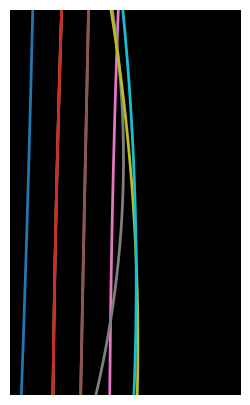

In [11]:
lines = finding_line(warped_mask, peaks)
pprint(lines)
plot_fitting_lines(warped_mask, lines)

从上图可以发现，实际共有5条车道线，但得到了10个峰值点，且拟合出的10条曲线有3条是重叠的（红色、棕色分别重叠2、1次）。

根据这些信息，可以采取两种解决办法：

- 在拟合前进行过滤
- 在拟合后进行过滤

### 在拟合前进行过滤

通过直方图不难看出，车道线的间距在20~30像素，且每条车道线的峰值像素个数不小于50。可以根据这些关系对数据进行过滤。

In [12]:
# 一次筛选
fpeaks = [index for index in peaks if vertical_projection[index] > 50]
print(f"==>> fpeaks: {fpeaks}")

# 二次筛选
filtered_peaks = [fpeaks[0]]
for i in range(1, len(fpeaks)):
    if fpeaks[i] - filtered_peaks[-1] < 20:
        # 如果 x 差值小于20，保留 y 值较大的点
        if fpeaks[i] > filtered_peaks[-1]:
            filtered_peaks[-1] = fpeaks[i]
    else:
        # 如果 x 差值大于等于20，直接添加到筛选后的列表
        filtered_peaks.append(fpeaks[i])

print(f"==>> filtered_peaks: {filtered_peaks}")

==>> fpeaks: [27, 59, 62, 96, 99, 136, 163]
==>> filtered_peaks: [27, 62, 99, 136, 163]


[array([-1.30352505e-05, -2.30486201e-02,  2.90220098e+01]),
 array([ 2.12480717e-05, -3.31642565e-02,  6.65330824e+01]),
 array([ 2.43088698e-06, -2.16520833e-02,  1.01486570e+02]),
 array([ 3.01406741e-05, -3.71399438e-02,  1.40104435e+02]),
 array([-1.39268725e-04,  9.82965914e-02,  1.46070551e+02])]


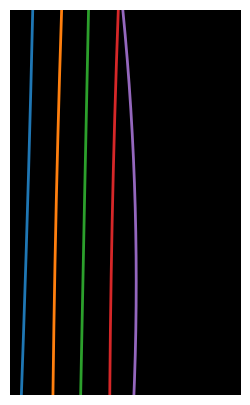

In [13]:
filter_lines = finding_line(warped_mask, filtered_peaks)
pprint(filter_lines)
plot_fitting_lines(warped_mask, filter_lines)

### 在拟合后进行过滤

由于使用二阶多项式对车道线拟合， 而二阶多项式系数在二次多项式方程中具有几何意义，这个方程一般表示为：

$$
	f(x) = ax^2 + bx + c
$$

其中，$a$, $b$, 和 $c$ 是系数，决定了二次多项式的形状。系数的组合产生了不同形状和位置的二次曲线，反映了二次多项式方程在平面上的几何特征。

上文我们已经知道了车道线的间距在20~30像素，可以通过比较相邻两二次多项式在 $0 < f(x) < \text{{height}}$ 的情况下，以x的最大值作差，作为两车道线的间距。若间距小于20，则代表是一条车道线，保留其中系数 b 最接近于0的（曲率最小的）作为车道线。

In [14]:
filter_lines = []
for idx, line in enumerate(lines):
    y = np.linspace(0, warped_mask.shape[0]-1, warped_mask.shape[0])
    x = np.polyval(line, y)
    max_x = max(x)

    if idx == 0:
        filter_lines.append((x, y))
        prev_b, prev_max_x = line[1], max_x
    else:
        if abs(max_x - prev_max_x) < 20:
            if abs(prev_b) > abs(line[1]):
                filter_lines[-1] = (x, y)
                prev_b, prev_max_x = line[1], max_x
        else:
            filter_lines.append((x, y))
            prev_b, prev_max_x = line[1], max_x

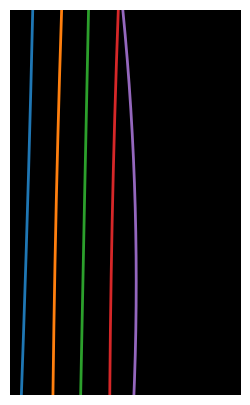

In [15]:
plot_filter_lines(warped_mask, filter_lines, filename='./data/output/filter_lines.png')

## 将拟合后的车道线投影到原图上

在完成车道线的拟合后，可以将拟合出的车道线投影回原始图像中。这个过程涉及逆透视变换，将鸟瞰图上的车道线投影回原始图像上。


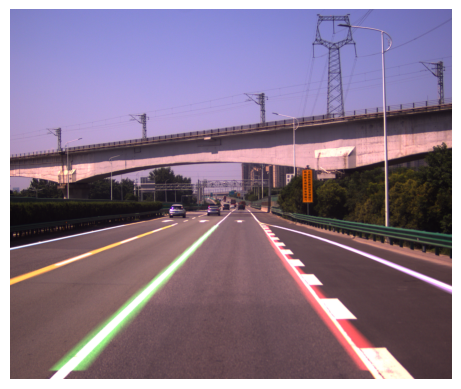

In [16]:
img = cv2.imread('./data/output/filter_lines.png')
newwarp = cv2.warpPerspective(img, np.linalg.inv(Matrix), (image.shape[1], image.shape[0])) 
result = cv2.addWeighted(image, 1, newwarp, 1, 0)

plt.imshow(result[:,:,::-1])
plt.axis('off')
plt.show()